In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
import matplotlib.patches as mpatches

from timeit import default_timer as timer


import settings_gfpkq  as st         # configuration file (update 2/June/22)
import helper as hp   

# Simple Gaussian process class adapted for the emulator
from gaussproc_emu import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Growth Factor post training x-check

In [2]:
root_dir = "./"

In [3]:
if st.sigma8:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, sigma8, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset','cosmologies_sig8')
    tag="sigma8"
else:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset', 'cosmologies_As')
    tag="As"

In [4]:
print(f"Cosmo[{tag}]: nber of training Cosmo points {cosmologies.shape[0]} for {cosmologies.shape[1]} params")

Cosmo[sigma8]: nber of training Cosmo points 1000 for 5 params


In [5]:
#min/max of
# Omega_cdm h^2, Omega_b h^2, sigma8, ns, h    OR
# Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h

np.min(cosmologies,axis=0), np.max(cosmologies,axis=0)

(array([0.06007758, 0.01900376, 0.25284093, 0.70017789, 0.64001778]),
 array([0.39991897, 0.0259947 , 3.24888822, 1.29993568, 0.8199316 ]))

In [6]:
print(f"Order of polynomial approx: {st.order}")
print(f"Whitening of x_train: {st.x_trans}")
print(f"Transformation of y_tain: {st.gf_args}")
print(f"outputs are centred on zero: {st.use_mean}")
print(f"noise covariance matrix: {st.var}")
print(f"Matrix diag term for stability: { st.jitter}")

Order of polynomial approx: 2
Whitening of x_train: True
Transformation of y_tain: {'y_trans': False, 'lambda_cap': 1}
outputs are centred on zero: False
noise covariance matrix: 1e-05
Matrix diag term for stability: 1e-05


In [7]:
#########
if st.sigma8:
    growth_factor = hp.load_arrays(root_dir + 'trainingset/components_sig8', 'growth_factor')
else:
    growth_factor = hp.load_arrays(root_dir + 'trainingset/components_As', 'growth_factor')

print(f"Growth Fact: nber of training points {growth_factor.shape[0]} for {growth_factor.shape[1]} z (linear)")

######

n_gf = growth_factor.shape[1]
print(f"The number of GPs to model Growth={n_gf} (= nber of z_bins) ")
if  st.sigma8:
    folder_gf = root_dir + '/pknl_components' + st.d_one_plus +'_sig8_Matern12' + '/gf'
else:
    folder_gf = root_dir + '/pknl_components' + st.d_one_plus + '_As' + '/gf'
    

arg_gf = [[cosmologies, growth_factor[:, i], st.gf_args, folder_gf, 'gp_' + str(i)] for i in range(n_gf)]

Growth Fact: nber of training points 1000 for 20 z (linear)
The number of GPs to model Growth=20 (= nber of z_bins) 


# Post training : (emu_i(theta_j) - y_ij)/y_ij

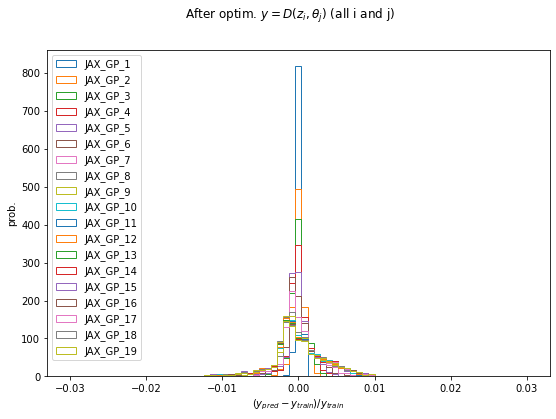

In [11]:
fig, ax = plt.subplots(figsize=(9,6))

first = True

medians = []
means = []
sigmas = []
for i_gf in range(1,n_gf):
    # for the time beeing re-instance the class each time
    gp_model = GPEmu(kernel=kernel_Matern12, #kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.gf_args['y_trans'],
                         use_mean=st.use_mean)
    
    #print(f"Process GP_{i_gf}/{n_gf}")
    arg_cur_gp = arg_gf[i_gf][2]
    theta = arg_gf[i_gf][0] # cosmo \Theta_i i<N_train
    y = arg_gf[i_gf][1]     # growth D(zj[1],\Theta_i)
    arg_cur_gp["folder_name"] = arg_gf[i_gf][3]
    arg_cur_gp["file_name"] = arg_gf[i_gf][4]

    #load training 
    gp_model.load_info(arg_cur_gp["folder_name"],arg_cur_gp["file_name"])
#    print(f"GP_{i_gf}",gp_model.mean_theta, gp_model.x_trans, gp_model.transform.mu_matrix,
#          gp_model.kernel_hat, gp_model.beta_hat, gp_model.kinv_XX_res[:10],
#          gp_model.mean_function, gp_model.x_train[:10])
    
    diff = (gp_model.simple_predict(theta)-y)/y
    
#    print('diff:',diff)
    
    medians.append(np.median(diff))
    means.append(np.mean(diff))
    sigmas.append(np.std(diff))
    
    if first:
        _,bins,_ = ax.hist(np.array(diff),bins=75, density=False, histtype='step',
                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_gf}');
        first = False
    else:
        ax.hist(np.array(diff),bins=bins, density=False, histtype='step',
                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_gf}');
        
    
ax.legend(loc='upper left', fontsize=10)
ax.set_xlabel(r"$(y_{pred}-y_{train})/y_{train}$");
ax.set_ylabel('prob.')    
fig.suptitle(r"After optim. $y=D(z_i,\theta_j)$ (all i and j)");

In [12]:
theta = arg_gf[0][0]

In [13]:
theta

array([[0.12616742, 0.02163407, 1.18279248, 1.15724975, 0.73022459],
       [0.29972099, 0.02306631, 2.30523194, 0.86839526, 0.70286242],
       [0.13884111, 0.02485885, 1.58958545, 1.11576076, 0.76722837],
       ...,
       [0.38322584, 0.02537082, 2.92673794, 0.80712803, 0.64501174],
       [0.06389384, 0.01991875, 1.27428548, 1.28515481, 0.64342292],
       [0.2368161 , 0.02314526, 1.39656194, 0.95206408, 0.80532434]])

In [14]:
arg_gf[0][2]

{'y_trans': False,
 'lambda_cap': 1,
 'folder_name': './/pknl_components_op_sig8_Matern12/gf',
 'file_name': 'gp_19'}

In [16]:
medians=np.array(medians)
means=np.array(means)
sigmas=np.array(sigmas)

In [17]:
zs=np.linspace(st.zmin, st.zmax, st.nz, endpoint=True)

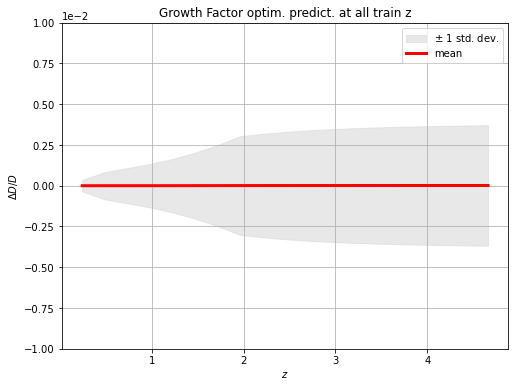

In [18]:
n_sig=1
plt.figure(figsize=(8,6))
plt.fill_between(zs[1:],means-n_sig*sigmas,means+n_sig*sigmas, color="lightgray", 
                 label=fr"$\pm$ {n_sig} std. dev.", alpha=0.5)
plt.plot(zs[1:],means,c='red', lw=3, label='mean')
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"$\Delta D/D$")
plt.ylim([-1e-2,1e-2])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.grid()
plt.title("Growth Factor optim. predict. at all train z");